# Scalar [Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)) of Digital Signals

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np

In [12]:
def plot_quantizer(x_plot, y_plot, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_label_coords(1,0.40)
    ax.xaxis.set_label_text('Input')
    ax.yaxis.set_label_coords(0.45,.9)
    ax.yaxis.set_label_text('Output')

    ticks = np.arange(-8, 9, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.grid()
    ax.plot(x_plot, y_plot)

In [115]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [14]:
def print_center(x, y, z, n):
    offset = (len(x)-n)//2
    for i in range(n):
        input = int(x[i+offset])
        output = int(y[i+offset])
        recons = int(z[i+offset])
        print(f"{input:>6d} {output:>6d} {recons:>6d}")

## A.  Uniform Quantization

### A.a. [Mid-tread ("round") Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Example)

Quantization index
\begin{equation}
  k=\Big\lfloor \frac{x}{\Delta} + \frac{1}{2}\Big\rfloor.
\end{equation}

Reconstructed value
\begin{equation}
  y = \Delta k.
\end{equation}

The $k$ index can be also computed using the [round half toward zero](https://en.wikipedia.org/wiki/Rounding#Round_half_towards_zero) (or round to the nearest integer), for which NumPy provides the method [rint()](https://numpy.org/doc/stable/reference/generated/numpy.rint.html).

In [46]:
def midtread_quantizer(x, quantization_step):
    k = np.rint(x / quantization_step)
    # k = np.floor(x/quantization_step + 0.5)
    return k

def midtread_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

### A.b. [Mid-rise ("truncation") Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Mid-riser_and_mid-tread_uniform_quantizers)

Quantization index
\begin{equation}
  k=\Big\lfloor \frac{x}{\Delta}\Big\rfloor.
\end{equation}

Reconstructed value
\begin{equation}
  y = \Delta \Big(k + \frac{1}{2}\Big).
\end{equation}

In [59]:
def midrise_quantizer(x, quantization_step):
    k = np.floor(x / quantization_step)
    return k

def midrise_dequantizer(k, quantization_step):
    y = quantization_step * (k + 0.5)
    return y
    #return y * quantization_step + quantization_step/2

### A.c. [Dead-zone Quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)#Dead-zone_quantizers)

Quantization index
\begin{equation}
  k = \text{sgn}(x) \max\left(0, \left\lfloor \frac{\left| x \right|-w/2}{\Delta}+1\right\rfloor\right).
\end{equation}

Reconstructed value
\begin{equation}
  y = \text{sgn}(k) \left(\frac{w}{2}+\Delta(|k|-1+r_k)\right).
\end{equation}

If $w=\Delta$ and $r_k=1/2$, then the first equation becomes
\begin{equation}
  k = \text{sgn}(x) \max\left(0, \left\lfloor \frac{\left| x \right|}{\Delta} + \frac{1}{2}\right\rfloor\right),
\end{equation}
which can be computed efficiently in NumPy by simply converting the floating point representation of $x/\Delta$ to an integer using the [astype()](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html) method. Using the same simplification, the second equation boils down to
\begin{equation}
  y = \Delta k.
\end{equation}


In [72]:
def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

## B. [Non Uniform Quantization](https://nptel.ac.in/content/storage2/courses/117104069/chapter_5/5_5.html)

### B.a. [Companded (COMpressed + exPANDED)](https://en.wikipedia.org/wiki/Companding) Quantization

#### B.a.1. [$\mu$-Law](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm) Companded  Quantization

Compressor
\begin{equation}
C(x) = \text{sgn}(x) \frac{\ln(1+ \mu |x|)}{\ln(1+\mu)}, ~~~~-1 \leq x \leq 1,
\end{equation}
shere $\mu=255$ in most implementations.

Expander:
\begin{equation}
C^{-1}(y) = \text{sgn}(y) (1 / \mu ) ((1 + \mu)^{|y|}- 1),~~~~-1 \leq y \leq 1.
\end{equation}

In [73]:
def muLaw_compress(x, mu):
    return np.log(1+mu*np.abs(x))/np.log(1+mu)*np.sign(x)

In [116]:
def muLaw_expand(y, mu):
    return (1/mu)*(((1+mu)**np.abs(y))-1)*np.sign(y)

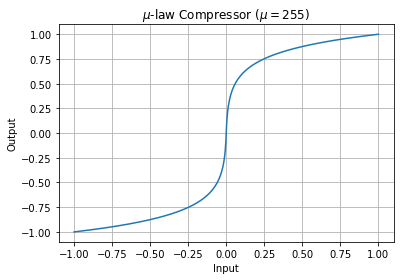

In [117]:
x = np.linspace(-1, 1, 500)

mu = 255
y = muLaw_compress(x, mu)
plot(x, y, "Input", "Output", "$\mu$-law Compressor ($\mu={}$)".format(mu))

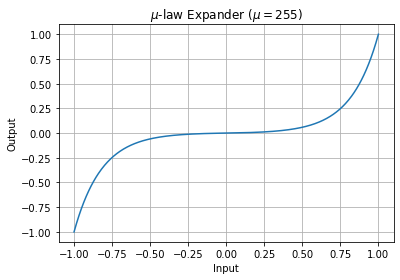

In [118]:
x = np.linspace(-1, 1, 500)

mu = 255
y = muLaw_expand(x, mu)
plot(x, y, "Input", "Output", "$\mu$-law Expander ($\mu={}$)".format(mu))

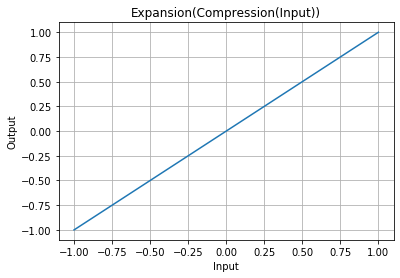

In [119]:
mu = 255
x = np.linspace(-1, 1, 500)
y = muLaw_compress(x, mu)
x_recons = muLaw_expand(y, mu)
plot(x, x_recons, "Input", "Output", "Expansion(Compression(Input))".format(mu))

After these definitions, we define the quantization index
\begin{equation}
  k = Q\big(C(x)\big),
\end{equation}
where $C$ is the compression function and $Q$ is a dead-zone quantizer. 

Reconstruction value
\begin{equation}
  y = C^{-1}\big(Q^{-1}(k)\big),
\end{equation}
where $Q^{-1}$ stands for the dead-zone dequantizer and $C^{-1}$ for the expander function.

In [120]:
def companded_quantizer(x, quantization_step):
    '''Companded mu-law deadzone quantizer'''
    mu = 255
    x_compressed = (32768*(muLaw_compress(x/32768, mu)))
    k = deadzone_quantizer(x_compressed, quantization_step)
    return k

def companded_dequantizer(k, quantization_step):
    '''Companded mu-law deadzone dequantizer'''
    mu = 255
    z_compressed = deadzone_dequantizer(k, quantization_step)
    y = np.round(32768*muLaw_expand(z_compressed/32768, mu)).astype(np.int16)
    return y

## Comparing Quantizers I/O

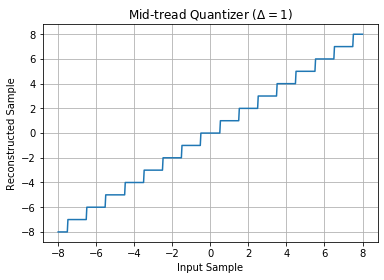

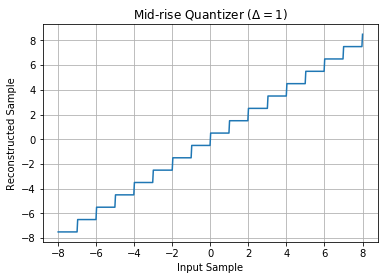

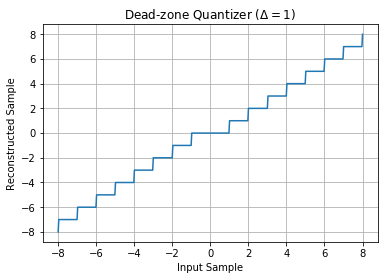

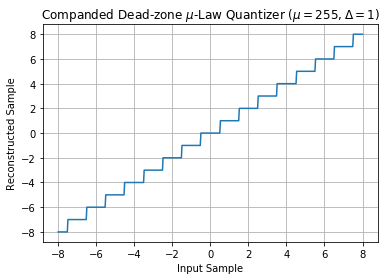

In [95]:
quantization_step = 1 # Delta
x = np.linspace(-8, 8, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

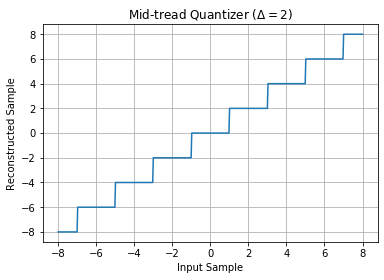

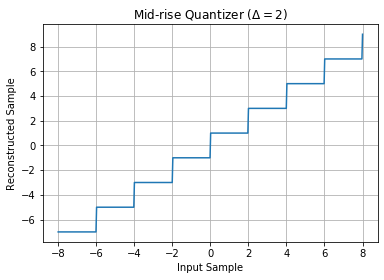

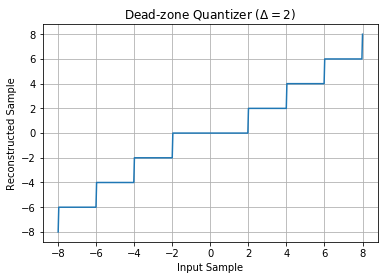

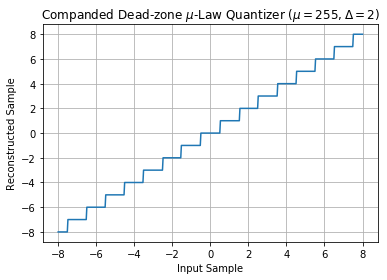

In [96]:
quantization_step = 2 # Delta
x = np.linspace(-8, 8, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

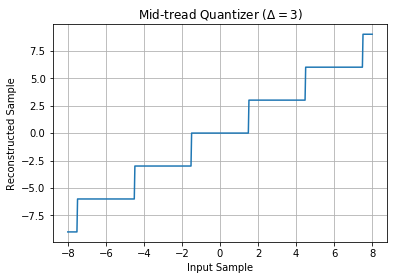

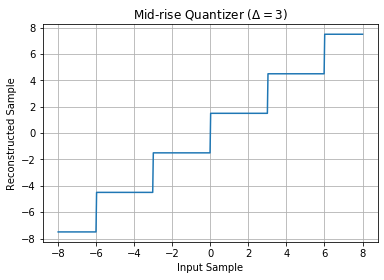

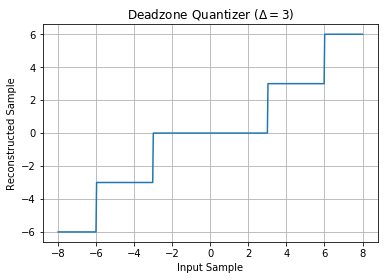

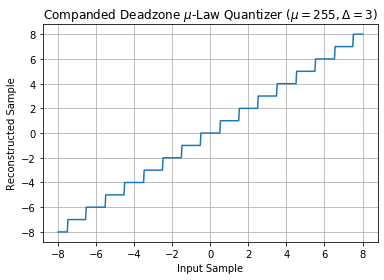

In [97]:
quantization_step = 3 # Delta
x = np.linspace(-8, 8, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_D, "Input Sample", "Reconstructed Sample", "Deadzone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

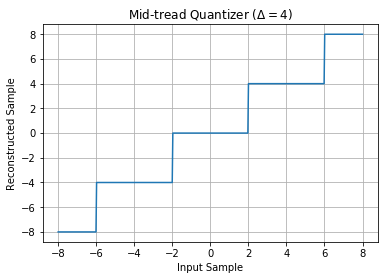

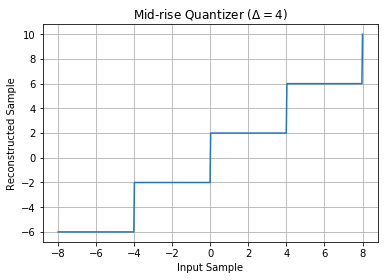

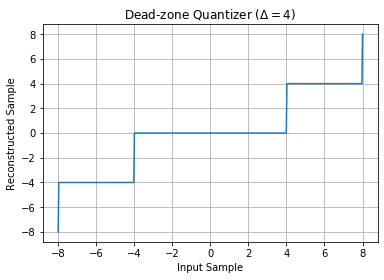

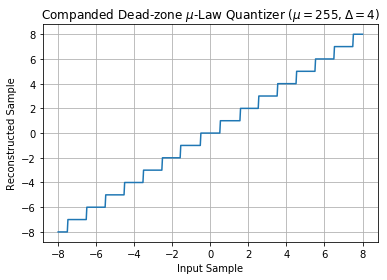

In [98]:
quantization_step = 4 # Delta
x = np.linspace(-8, 8, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

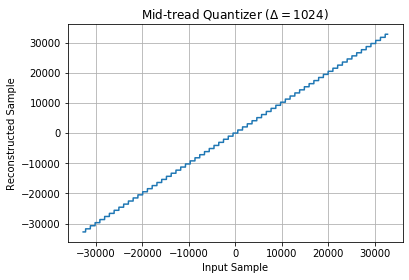

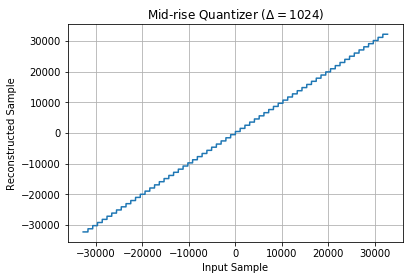

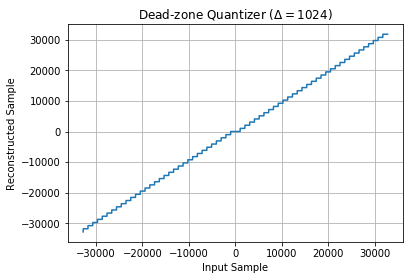

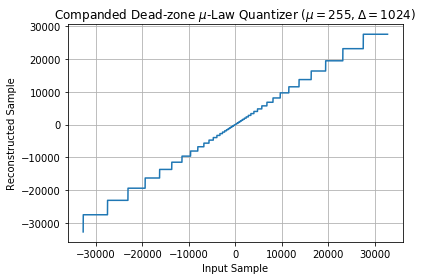

In [99]:
quantization_step = 1024
x = np.linspace(-32768, 32767, 65536)
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
plot(x, y_T, "Input Sample", "Reconstructed Sample", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_R, "Input Sample", "Reconstructed Sample", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_D, "Input Sample", "Reconstructed Sample", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, y_C, "Input Sample", "Reconstructed Sample", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

## Comparing quantization error

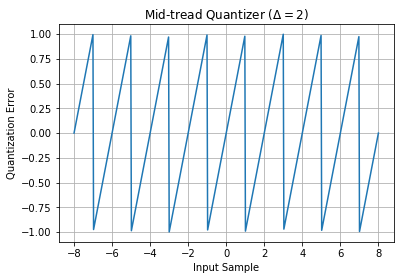

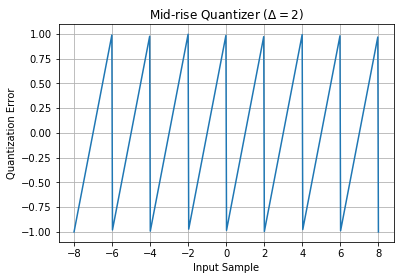

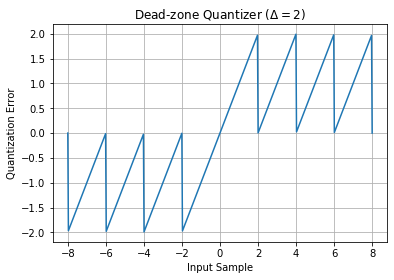

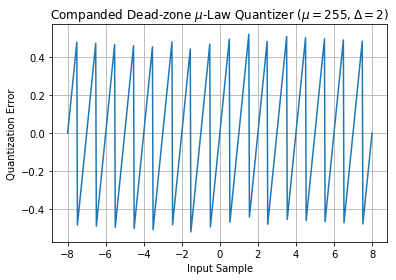

In [100]:
quantization_step = 2 # Delta
x = np.linspace(-8, 8, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

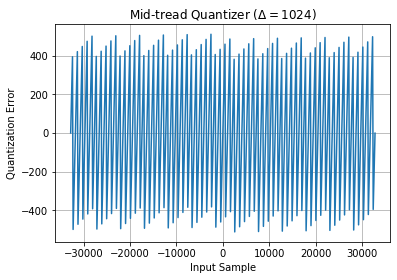

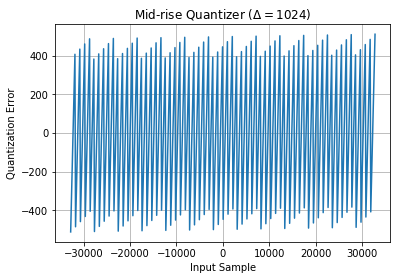

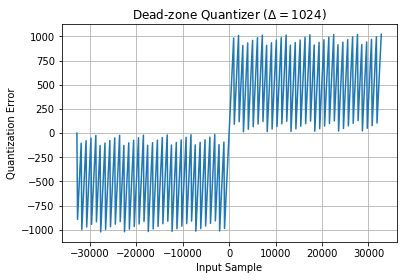

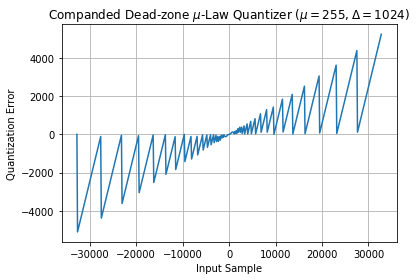

In [101]:
quantization_step = 1024 # Delta
x = np.linspace(-32768, 32767, 500) # Input samples
k_T = midtread_quantizer(x, quantization_step) # Quantized samples
y_T = midtread_dequantizer(k_T, quantization_step) # Reconstructed samples
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C
plot(x, error_T, "Input Sample", "Quantization Error", "Mid-tread Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_R, "Input Sample", "Quantization Error", "Mid-rise Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_D, "Input Sample", "Quantization Error", "Dead-zone Quantizer ($\Delta={}$)".format(quantization_step))
plot(x, error_C, "Input Sample", "Quantization Error", "Companded Dead-zone $\mu$-Law Quantizer ($\mu={}, \Delta={}$)".format(mu, quantization_step))

## Working with signed integers of 16 bits

In [102]:
quantization_step = 2
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
k_T = midtread_quantizer(x, quantization_step)
y_T = midtread_dequantizer(k_T, quantization_step)
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)

n = 16
print(f"{'Mid-tread':>20s} {'Mid-rise':>20s} {'Dead-zone':>20s} {'Companded Dead-zone':>20s}")
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s}")
offset = (len(x)-n)//2
for i in range(n):
    input = int(x[i+offset])
    output_T = int(k_T[i+offset])
    recons_T = int(y_T[i+offset])
    print(f"{input:>6d} {output_T:>6d} {recons_T:>6d}", end='')
    output_R = int(k_R[i+offset])
    recons_R = int(y_R[i+offset])
    print(f" {input:>6d} {output_R:>6d} {recons_R:>6d}", end='')
    output_D = int(k_D[i+offset])
    recons_D = int(y_D[i+offset])
    print(f" {input:>6d} {output_D:>6d} {recons_D:>6d}", end='')
    output_C = int(k_C[i+offset])
    recons_C = int(y_C[i+offset])
    print(f" {input:>6d} {output_C:>6d} {recons_C:>6d}")


           Mid-tread             Mid-rise            Dead-zone  Companded Dead-zone
 Input Output Recons  Input Output Recons  Input Output Recons  Input Output Recons
    -8     -4     -8     -8     -4     -7     -8     -4     -8     -8   -178     -8
    -7     -4     -8     -7     -4     -7     -7     -3     -6     -7   -156     -7
    -6     -3     -6     -6     -3     -5     -6     -3     -6     -6   -134     -6
    -5     -2     -4     -5     -3     -5     -5     -2     -4     -5   -112     -5
    -4     -2     -4     -4     -2     -3     -4     -2     -4     -4    -90     -4
    -3     -2     -4     -3     -2     -3     -3     -1     -2     -3    -68     -3
    -2     -1     -2     -2     -1     -1     -2     -1     -2     -2    -45     -2
    -1      0      0     -1     -1     -1     -1      0      0     -1    -22     -1
     0      0      0      0      0      1      0      0      0      0      0      0
     1      0      0      1      0      1      1      0      0      1     22

In [103]:
quantization_step = 32
x = np.linspace(-32768, 32767, 65536).astype(np.int16)
k_T = midtread_quantizer(x, quantization_step)
y_T = midtread_dequantizer(k_T, quantization_step)
k_R = midrise_quantizer(x, quantization_step)
y_R = midrise_dequantizer(k_R, quantization_step)
k_D = deadzone_quantizer(x, quantization_step)
y_D = deadzone_dequantizer(k_D, quantization_step)
k_C = companded_quantizer(x, quantization_step)
y_C = companded_dequantizer(k_C, quantization_step)

n = 16
print(f"{'Mid-tread':>20s} {'Mid-rise':>20s} {'Dead-zone':>20s} {'Companded Dead-zone':>20s}")
print(f"{'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s} {'Input':>6s} {'Output':>6s} {'Recons':>6s}")
offset = (len(x)-n)//2
for i in range(n):
    input = int(x[i+offset])
    output_T = int(k_T[i+offset])
    recons_T = int(y_T[i+offset])
    print(f"{input:>6d} {output_T:>6d} {recons_T:>6d}", end='')
    output_R = int(k_R[i+offset])
    recons_R = int(y_R[i+offset])
    print(f" {input:>6d} {output_R:>6d} {recons_R:>6d}", end='')
    output_D = int(k_D[i+offset])
    recons_D = int(y_D[i+offset])
    print(f" {input:>6d} {output_D:>6d} {recons_D:>6d}", end='')
    output_C = int(k_C[i+offset])
    recons_C = int(y_C[i+offset])
    print(f" {input:>6d} {output_C:>6d} {recons_C:>6d}")


           Mid-tread             Mid-rise            Dead-zone  Companded Dead-zone
 Input Output Recons  Input Output Recons  Input Output Recons  Input Output Recons
    -8      0      0     -8     -1    -16     -8      0      0     -8    -11     -8
    -7      0      0     -7     -1    -16     -7      0      0     -7     -9     -6
    -6      0      0     -6     -1    -16     -6      0      0     -6     -8     -6
    -5      0      0     -5     -1    -16     -5      0      0     -5     -7     -5
    -4      0      0     -4     -1    -16     -4      0      0     -4     -5     -4
    -3      0      0     -3     -1    -16     -3      0      0     -3     -4     -3
    -2      0      0     -2     -1    -16     -2      0      0     -2     -2     -1
    -1      0      0     -1     -1    -16     -1      0      0     -1     -1     -1
     0      0      0      0      0     16      0      0      0      0      0      0
     1      0      0      1      0     16      1      0      0      1      1

# Which performs better for an audio signal?

In [104]:
def midtread_quantization(x, quantization_step):
    k = midtread_quantizer(x, quantization_step)
    y = midtread_dequantizer(k, quantization_step)
    return k, y

In [105]:
def midrise_quantization(x, quantization_step):
    k = midrise_quantizer(x, quantization_step)
    y = midrise_dequantizer(k, quantization_step)
    return k, y

In [106]:
def deadzone_quantization(x, quantization_step):
    k = deadzone_quantizer(x, quantization_step)
    y = deadzone_dequantizer(k, quantization_step)
    return k, y

In [107]:
def companded_quantization(x, quantization_step):
    k = companded_quantizer(x, quantization_step)
    y = companded_dequantizer(k, quantization_step)
    return k, y

## A subjective comparative

In [133]:
import sounddevice as sd
fs = 44100
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Speak!")
while sd.wait():
    pass
print("done")

Speak!
done


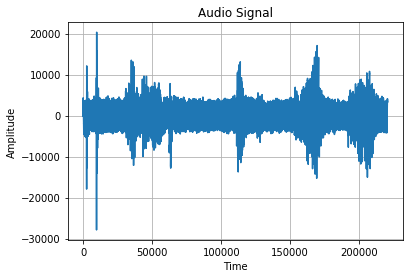

In [134]:
sd.play(x)
plot(np.linspace(0, len(x)-1, len(x)), x, "Time", "Amplitude", "Audio Signal")

In [135]:
quantization_step = 2000

In [136]:
k_T, y_T = midtread_quantization(x, quantization_step)
y_T = y_T.astype(np.int16)
k_R, y_R = midrise_quantization(x, quantization_step)
y_R = y_R.astype(np.int16)
k_D, y_D = deadzone_quantization(x, quantization_step)
y_D = y_D.astype(np.int16)
k_C, y_C = companded_quantization(x, quantization_step)
y_C = y_C.astype(np.int16)

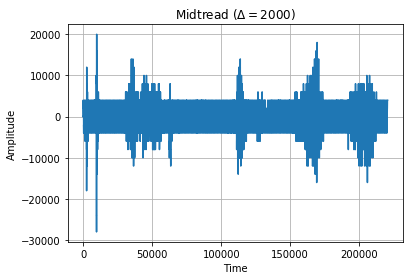

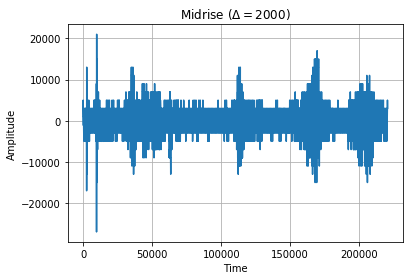

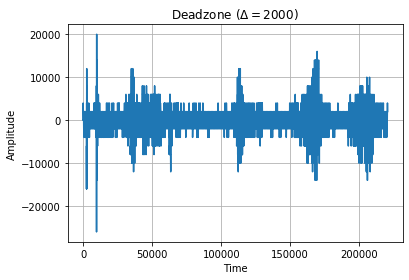

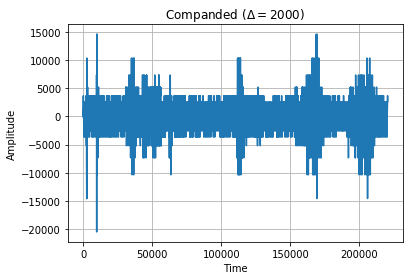

In [137]:
import time
sd.play(y_T)
plot(np.linspace(0, len(y_T)-1, len(y_T)), y_T, "Time", "Amplitude", "Mid-tread ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(y_R)
plot(np.linspace(0, len(y_R)-1, len(y_R)), y_R, "Time", "Amplitude", "Mid-rise ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(y_D)
plot(np.linspace(0, len(y_D)-1, len(y_D)), y_D, "Time", "Amplitude", "Dead-zone ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(y_C)
plot(np.linspace(0, len(y_C)-1, len(y_C)), y_C, "Time", "Amplitude", "Companded Dead-zone ($\Delta={}$)".format(quantization_step))

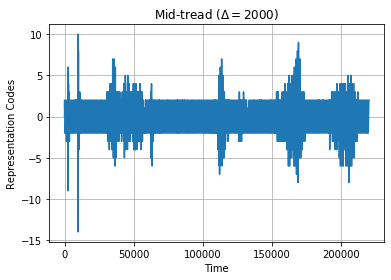

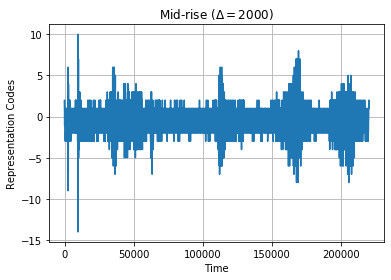

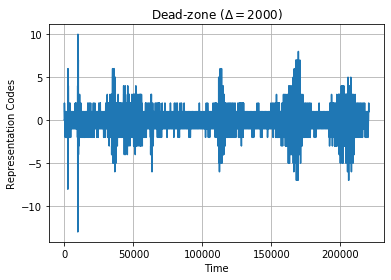

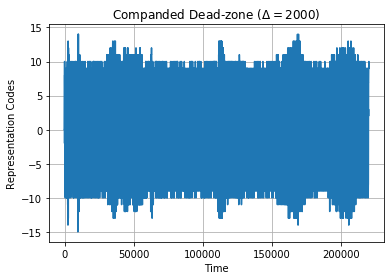

In [138]:
plot(np.linspace(0, len(k_T)-1, len(k_T)), k_T, "Time", "Representation Codes", "Mid-tread ($\Delta={}$)".format(quantization_step))
plot(np.linspace(0, len(k_R)-1, len(k_R)), k_R, "Time", "Representation Codes", "Mid-rise ($\Delta={}$)".format(quantization_step))
plot(np.linspace(0, len(k_D)-1, len(k_D)), k_D, "Time", "Representation Codes", "Dead-zone ($\Delta={}$)".format(quantization_step))
plot(np.linspace(0, len(k_C)-1, len(k_C)), k_C, "Time", "Representation Codes", "Companded Dead-zone ($\Delta={}$)".format(quantization_step))

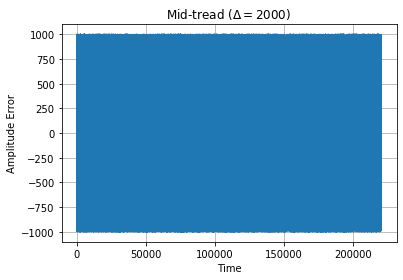

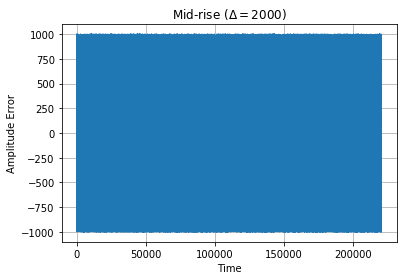

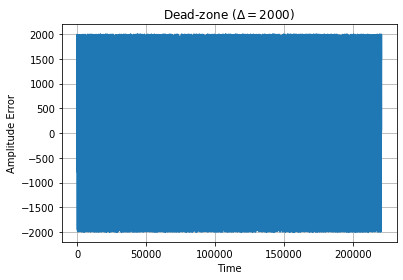

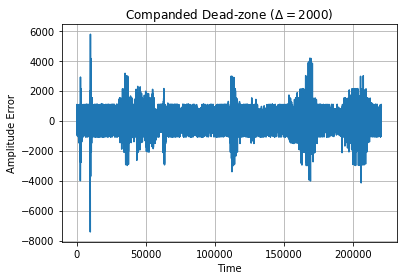

In [139]:
error_T = x - y_T
error_R = x - y_R
error_D = x - y_D
error_C = x - y_C

sd.play(error_T)
plot(np.linspace(0, len(y_T)-1, len(y_T)), error_T, "Time", "Amplitude Error", "Mid-tread ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(error_R)
plot(np.linspace(0, len(y_R)-1, len(y_R)), error_R, "Time", "Amplitude Error", "Mid-rise ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(error_D)
plot(np.linspace(0, len(y_D)-1, len(y_D)), error_D, "Time", "Amplitude Error", "Dead-zone ($\Delta={}$)".format(quantization_step))
time.sleep(duration)

sd.play(error_C)
plot(np.linspace(0, len(y_C)-1, len(y_C)), error_C, "Time", "Amplitude Error", "Companded Dead-zone ($\Delta={}$)".format(quantization_step))

## Objective comparative

### Using RMSE 

In [140]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

In [141]:
def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

In [142]:
# Based on https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

In [143]:
def RD_curve(x, quantization):
    RD_points = []
    for q_step in range(1, 32768, 32):
        k, y = quantization(x, q_step)
        rate = entropy_in_bits_per_symbol(k)
        distortion = RMSE(x, y)
        RD_points.append((rate, distortion))
    return RD_points

In [144]:
midtread_RD_points = RD_curve(x, midtread_quantization)
midrise_RD_points = RD_curve(x, midrise_quantization)
deadzone_RD_points = RD_curve(x, deadzone_quantization)
companded_RD_points = RD_curve(x, companded_quantization)

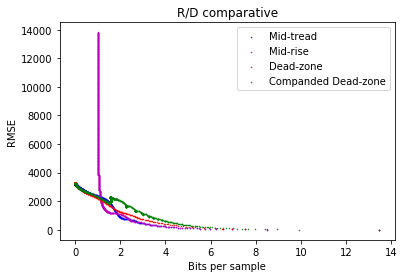

In [147]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("RMSE")
plt.scatter(*zip(*midtread_RD_points), s=1, c='b', marker=".", label='Mid-tread')
plt.scatter(*zip(*midrise_RD_points), s=1, c='m', marker=".", label='Mid-rise')
plt.scatter(*zip(*deadzone_RD_points), s=1, c='r', marker=".", label='Dead-zone')
plt.scatter(*zip(*companded_RD_points), s=1, c='g', marker=".", label='Companded Dead-zone')
plt.legend(loc='upper right')
plt.show()

### Using a logaritmic version of RMSE

In [148]:
def log_average_energy(x):
    '''In fact, average logaritmic energy.'''
    return np.sum(np.log(np.abs(x.astype(np.double))+1)*np.log(np.abs(x.astype(np.double))+1))/len(x)

In [149]:
def log_RMSE(x, y):
    error_signal = x - y
    return math.sqrt(log_average_energy(error_signal))

In [150]:
def log_RD_curve(x, quantization):
    RD_points = []
    for q_step in range(1, 32768, 32):
        k, y = quantization(x, q_step)
        rate = entropy_in_bits_per_symbol(k)
        distortion = log_RMSE(x, y)
        RD_points.append((rate, distortion))
    return RD_points

In [151]:
log_midtread_RD_points = log_RD_curve(x, midtread_quantization)
log_midrise_RD_points = log_RD_curve(x, midrise_quantization)
log_deadzone_RD_points = log_RD_curve(x, deadzone_quantization)
log_companded_RD_points = log_RD_curve(x, companded_quantization)

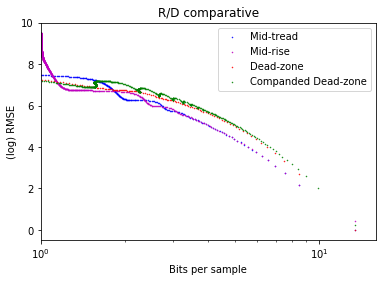

In [152]:
plt.title("R/D comparative")
plt.xlabel("Bits per sample")
plt.ylabel("(log) RMSE")
plt.yscale("linear")
plt.xscale("log")
plt.xlim(1, 16)
plt.scatter(*zip(*log_midtread_RD_points), s=1, c='b', marker=".", label='Mid-tread')
plt.scatter(*zip(*log_midrise_RD_points), s=1, c='m', marker=".", label='Mid-rise')
plt.scatter(*zip(*log_deadzone_RD_points), s=1, c='r', marker=".", label='Dead-zone')
plt.scatter(*zip(*log_companded_RD_points), s=1, c='g', marker=".", label='Companded Dead-zone')
plt.legend(loc='upper right')
plt.show()

In [ ]:

def SNR(x, y):
    signal_energy = compute_average_energy(x)
    error_energy = compute_average_energy(x-y)
    print("signal energy =", signal_energy)
    print("error energy =", error_energy)
    return 10*math.log(signal_energy/error_energy)